# Issue #1663 (PyTorch)

In [75]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.models import resnet

from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.models import load_model

from art.estimators.classification.pytorch import PyTorchClassifier
from art.attacks.evasion import AdversarialPatchPyTorch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, Compose, transforms

import cv2
import matplotlib
import matplotlib.pyplot as plt

import PIL.Image
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

import os
import glob
import gzip
import pickle

plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"

'''
Predict top 5 classes for image
'''
def predict_model(classifier, image):
    plt.axis("off")
    plt.imshow(image.transpose(1,2,0))
    plt.show()

    predictions = classifier.predict(np.array([image]))
    predictions = torch.nn.functional.softmax(torch.Tensor(predictions), dim=1).numpy()

    top_5 = np.argsort(-predictions)[:, :5]

    for idx in top_5[0].tolist():
        print(label_to_name(idx)+':', predictions[0][idx])

#### Hyperparameters

In [120]:
target_name = 'goldfish, Carassius auratus'
image_shape = (3, 224, 224)
clip_values = (0, 1)
nb_classes  = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

#### Model definition

In [121]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

ptc = PyTorchClassifier(model=model, loss=torch.nn.CrossEntropyLoss, nb_classes=nb_classes, 
                                        input_shape=image_shape, clip_values=clip_values, device_type="cuda",
                                        preprocessing=(MEAN, STD))

## ImageNet images

Load images, convert RGB to BGR. Further preprocessing passed to TensorFlowV2Classifier: zero-center each color channel with respect to ImageNet dataset [without scaling](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input#:~:text=The%20images%20are%20converted%20from%20RGB%20to%20BGR%2C%20then%20each%20color%20channel%20is%20zero%2Dcentered%20with%20respect%20to%20the%20ImageNet%20dataset%2C%20without%20scaling).

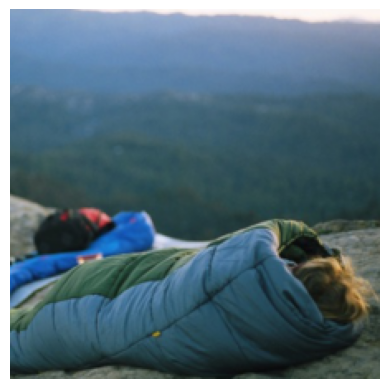

sleeping bag: 0.3727104
mountain tent: 0.02019634
binoculars, field glasses, opera glasses: 0.012218014
valley, vale: 0.008150697
volcano: 0.007430867


In [122]:
images_list = list()
preprocess = transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

for image_path in imagenet_stubs.get_image_paths():
    im = PIL.Image.open(image_path)
    im = preprocess(im).numpy()
    images_list.append(im)

images = np.array(images_list)

predict_model(ptc, images[0])

#### Generate Adversarial Patch

Adversarial Patch PyTorch:   0%|          | 0/500 [00:00<?, ?it/s]

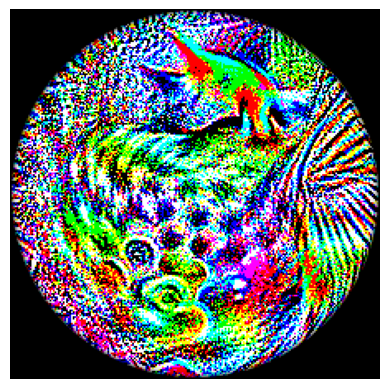

In [123]:
ap = AdversarialPatchPyTorch(estimator=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(3, 224, 224), verbose=True)

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

#### Apply the adversarial patch to images

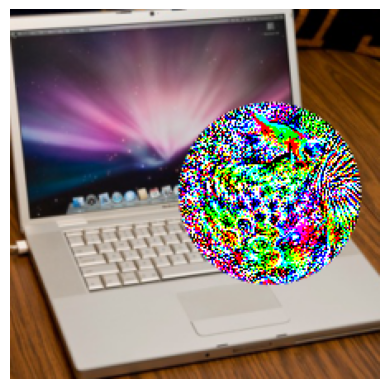

goldfish, Carassius auratus: 0.25705168
notebook, notebook computer: 0.10690822
laptop, laptop computer: 0.059973363
mouse, computer mouse: 0.013612473
space bar: 0.012005532


In [128]:
patched_images = ap.apply_patch(images, scale=0.5)
predict_model(ptc, patched_images[-1])

## ImageNet-Patch source images
Image data located in [imagenet-patch repository](https://github.com/pralab/ImageNet-Patch)

Prediction for image without patch:


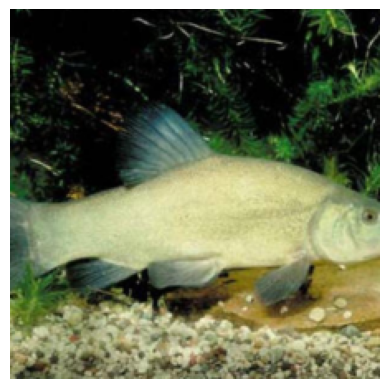

tench, Tinca tinca: 0.4179252
goldfish, Carassius auratus: 0.0034046457
barracouta, snoek: 0.0028792059
puffer, pufferfish, blowfish, globefish: 0.0027296727
anemone fish: 0.00215115


Adversarial Patch PyTorch:   0%|          | 0/500 [00:00<?, ?it/s]

Generated patch and prediction:


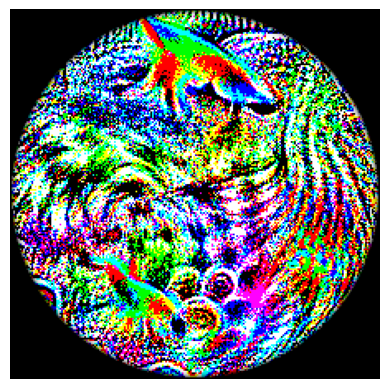

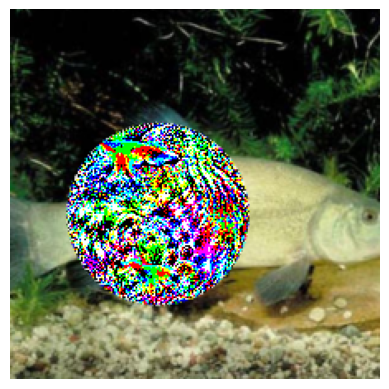

goldfish, Carassius auratus: 0.21989237
tench, Tinca tinca: 0.058994368
eft: 0.012216073
golf ball: 0.0043579214
axolotl, mud puppy, Ambystoma mexicanum: 0.004162967


In [82]:
images = glob.glob(os.path.join(os.getcwd(), "assets/data/n01440764")+'/*.JPEG')+\
    glob.glob(os.path.join(os.getcwd(), "assets/data/n02102040")+'/*.JPEG')+\
        glob.glob(os.path.join(os.getcwd(), "assets/data/n03028079")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n02979186")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n03000684")+'/*.JPEG')

images_list = list()
for image_path in images:
    im = PIL.Image.open(image_path)
    im = preprocess(im).numpy()
    images_list.append(im)

images = np.array(images_list)

print('Prediction for image without patch:')
predict_model(ptc, images[0])


ap = AdversarialPatchPyTorch(estimator=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(3, 224, 224), verbose=True)

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

print('Generated patch and prediction:')
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

patched_images = ap.apply_patch(images, scale=0.5)
predict_model(ptc, patched_images[0])

## ImageNet-Patch patch images

Prediction for image without patch:


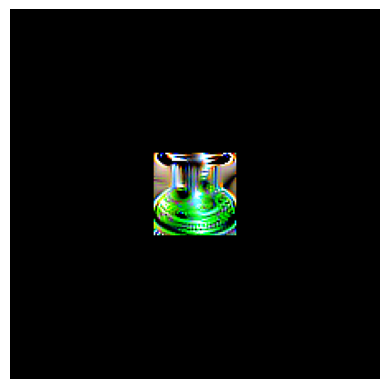

soap dispenser: 0.27648696
perfume, essence: 0.19455151
lotion: 0.047177136
hair spray: 0.012958349
pitcher, ewer: 0.012653148


Adversarial Patch PyTorch:   0%|          | 0/500 [00:00<?, ?it/s]

Generated patch and prediction:


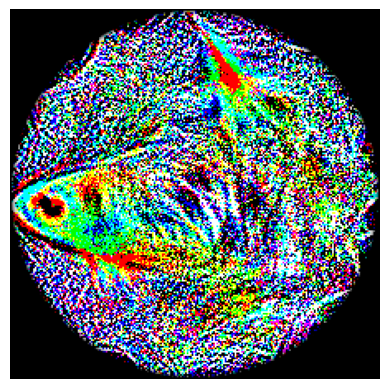

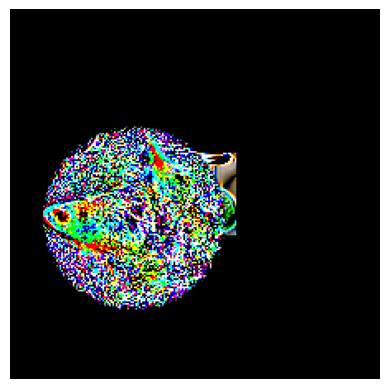

goldfish, Carassius auratus: 0.66522914
sea slug, nudibranch: 0.010080368
anemone fish: 0.008884562
goose: 0.008170192
hummingbird: 0.007883321


In [83]:
images = glob.glob(os.path.join(os.getcwd(), "assets/data/n01440764")+'/*.JPEG')+\
    glob.glob(os.path.join(os.getcwd(), "assets/data/n02102040")+'/*.JPEG')+\
        glob.glob(os.path.join(os.getcwd(), "assets/data/n03028079")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n02979186")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n03000684")+'/*.JPEG')

with gzip.open(os.path.join(os.getcwd(), "assets/imagenet_patch.gz"), 'rb') as f:
    imagenet_patch = pickle.load(f)
patches, targets, info = imagenet_patch
images = patches.numpy()

print('Prediction for image without patch:')
predict_model(ptc, images[0])


ap = AdversarialPatchPyTorch(estimator=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(3, 224, 224), verbose=True)

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

print('Generated patch and prediction:')
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

patched_images = ap.apply_patch(images, scale=0.5)
predict_model(ptc, patched_images[0])

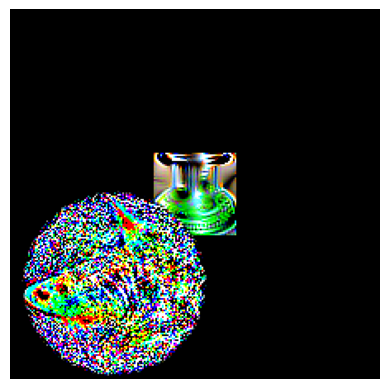

goldfish, Carassius auratus: 0.21714368
perfume, essence: 0.14147694
soap dispenser: 0.12932959
lotion: 0.016742354
pitcher, ewer: 0.009564364


In [109]:
patched_images = ap.apply_patch(images, scale=0.5)
predict_model(ptc, patched_images[0])